**Loading Libraries**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
# Loading the dataset
data = pd.read_csv('/content/netflix1.csv')

In [95]:
# Inspect the dataset
print(data.head())

  show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
4      s8    Movie                           Sankofa     Haile Gerima   

         country date_added  release_year rating  duration  \
0  United States  9/25/2021          2020  PG-13    90 min   
1         France  9/24/2021          2021  TV-MA  1 Season   
2  United States  9/24/2021          2021  TV-MA  1 Season   
3         Brazil  9/22/2021          2021  TV-PG    91 min   
4  United States  9/24/2021          1993  TV-MA   125 min   

                                           listed_in  
0                                      Documentaries  
1  Crime TV Shows, International TV Shows, TV Act...  
2                 TV Dr

In [96]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB
None


In [97]:
print(data.isnull().sum())
print(f"Shape before duplicates removal: {data.shape}")

show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64
Shape before duplicates removal: (8790, 10)


In [98]:
# Dropping the duplicates
data.drop_duplicates(inplace=True)
print(f"Shape after duplicates removal: {data.shape}")

Shape after duplicates removal: (8790, 10)


In [99]:
# Convert 'date_added' to datetime
data['date_added'] = pd.to_datetime(data['date_added'], errors = 'coerce')
# Show data types to confirm the changes
print(data.dtypes)

show_id                 object
type                    object
title                   object
director                object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
dtype: object


In [100]:
# SPlit duration into numeric value (for Movies)
data['duration_int'] = data['duration'].str.extract('(\d+)').astype(float)
data['duration_type'] = data['duration'].str.extract('([a-zA-Z]+)')

In [101]:
# Extract Year, Month, Day from date_added
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month
data['day_added'] = data['date_added'].dt.day

**Basic EDA Visualizations**

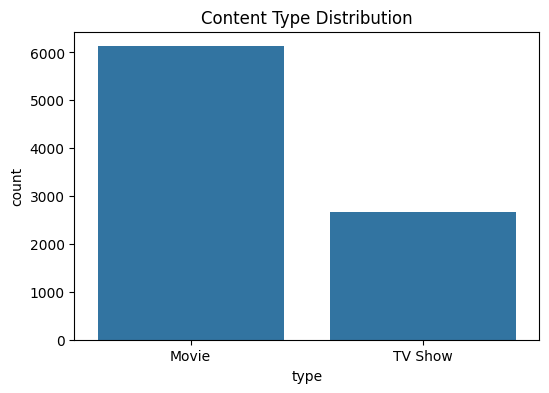

In [102]:
# 1. Distribution of Movies vs TV Shows
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='type')
plt.title('Content Type Distribution')
plt.show()

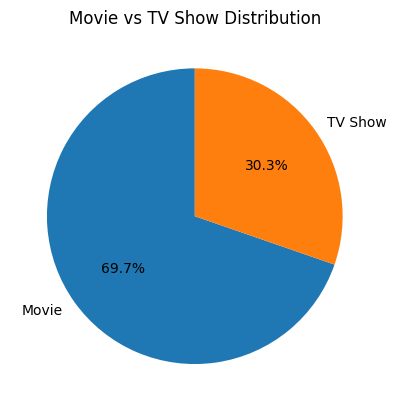

In [110]:
# 2. Pie Chart of content types
type_counts = data['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Movie vs TV Show Distribution')
plt.show()



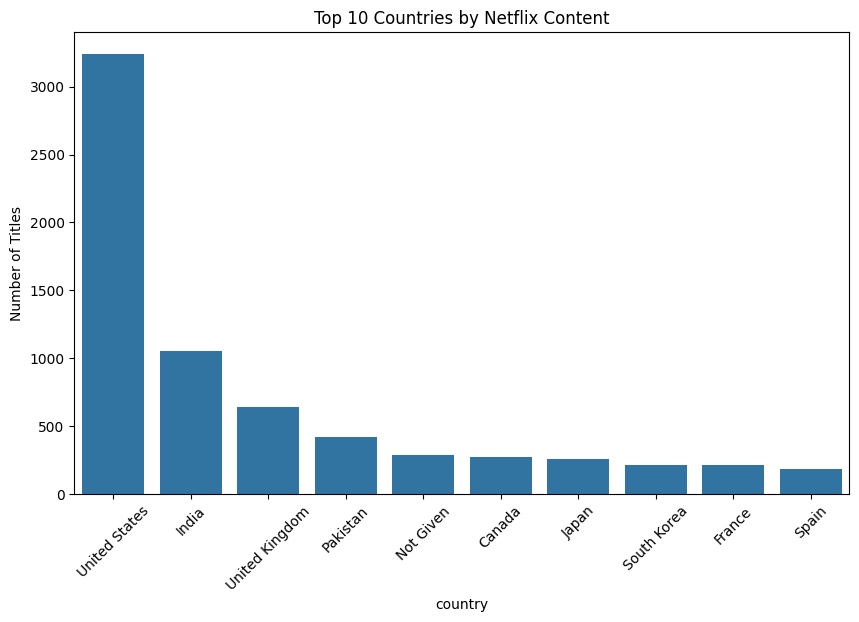

In [111]:
# 3. Top 10 countries by Content Count
top_countries = data['country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries by Netflix Content')
plt.xticks(rotation=45)
plt.ylabel('Number of Titles')
plt.show()

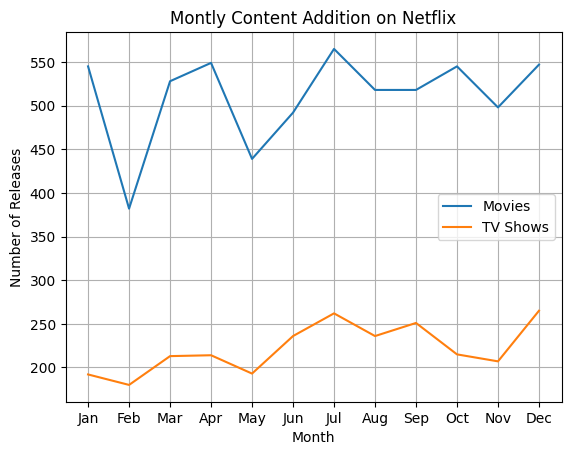

In [104]:
# 4. Monthly Releases: Movies vs TV Shows
monthly_movies = data[data['type']=='Movie']['month_added'].value_counts().sort_index()
monthly_shows = data[data['type']=='TV Show']['month_added'].value_counts().sort_index()

plt.plot(monthly_movies.index, monthly_movies.values, label='Movies')
plt.plot(monthly_shows.index, monthly_shows.values, label='TV Shows')
plt.title('Montly Content Addition on Netflix')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid()
plt.show()

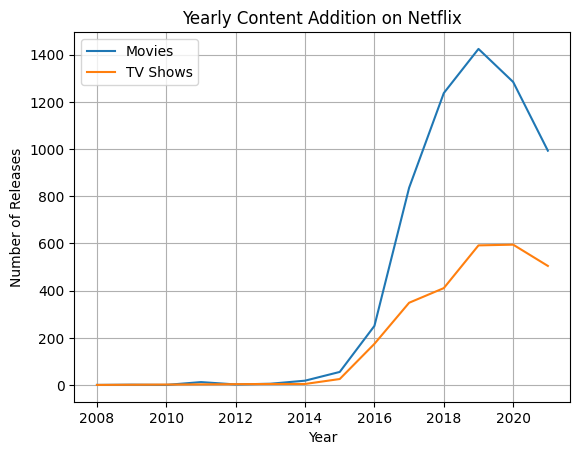

In [105]:
# 5. Yearly Content Releases
yearly_movies = data[data['type']=='Movie']['year_added'].value_counts().sort_index()
yearly_shows = data[data['type']=='TV Show']['year_added'].value_counts().sort_index()

plt.plot(yearly_movies.index, yearly_movies.values, label='Movies')
plt.plot(yearly_shows.index, yearly_shows.values, label='TV Shows')
plt.title('Yearly Content Addition on Netflix')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid()
plt.legend()
plt.show()

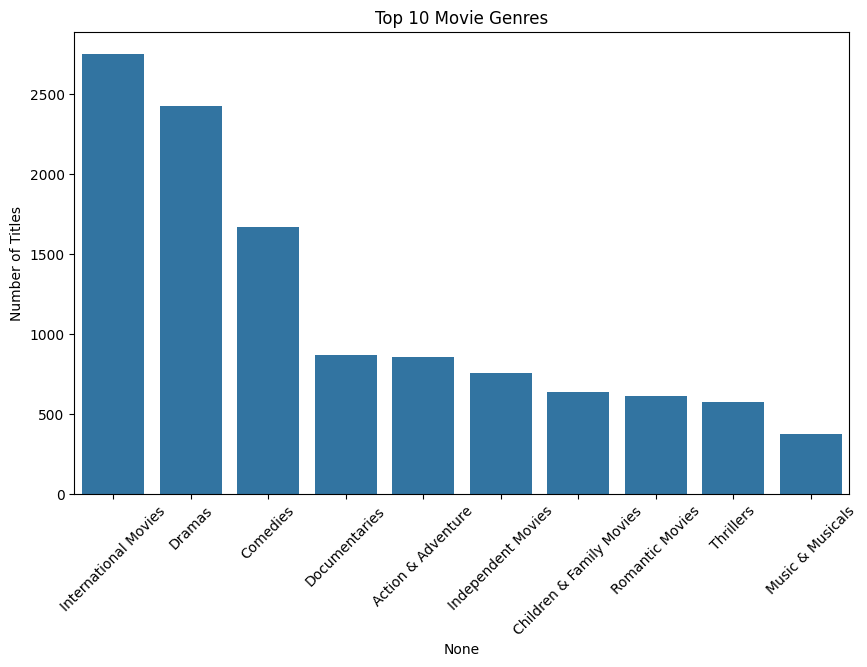

In [106]:
# 6. Top 10 Movie Genres
movie_genres = data[data['type']=='Movie']['listed_in'].str.split(', ')
all_genres = sum(movie_genres.dropna().tolist(), [])
genre_counts = pd.Series(all_genres).value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Top 10 Movie Genres')
plt.xticks(rotation=45)
plt.ylabel('Number of Titles')
plt.show()

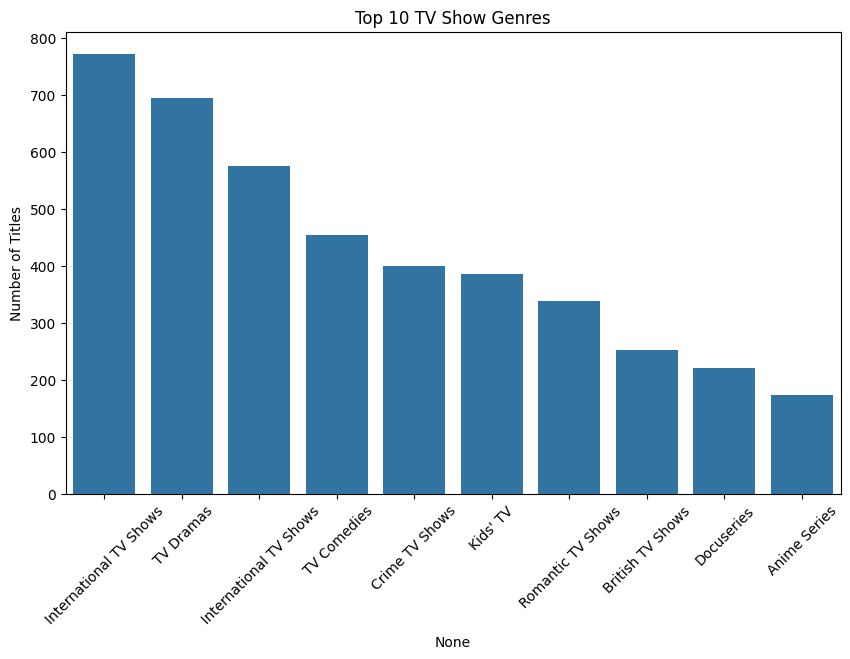

In [107]:
# 7. Top 10 TV Show Genres
show_genres = data[data['type']=='TV Show']['listed_in'].str.split(',')
all_genres_shows = sum(show_genres.dropna().tolist(), [])
genre_counts_shows = pd.Series(all_genres_shows).value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts_shows.index, y=genre_counts_shows.values)
plt.title('Top 10 TV Show Genres')
plt.xticks(rotation=45)
plt.ylabel('Number of Titles')
plt.show()

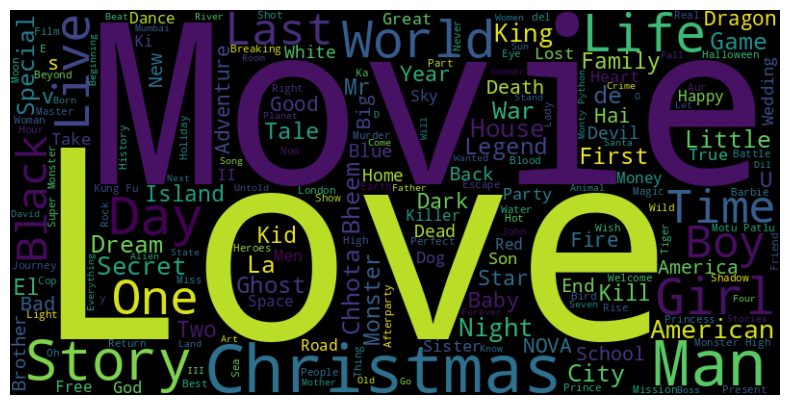

In [108]:
# 8. Word Cloud of Movie Titles
# Generate word cloud
movie_titles = data[data['type']=='Movie']['title']
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(movie_titles))

# Plot word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Feature Engineering**

In [109]:
# Improved ML Pipeline with More Features for Genre Count Prediction

# Additional feature engineering: Encoding 'type' and 'country' into numeric format
data['duration_int'] = data['duration'].str.extract('(\d+)').astype(float)
data['duration_type'] = data['duration'].str.extract('([a-zA-Z]+)')
data['duration_minutes'] = np.where(data['type'] == 'Movie', data['duration_int'], np.nan)
data['genre_count'] = data['listed_in'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
data['is_movie'] = np.where(data['type'] == 'Movie', 1, 0)
data['is_tv_show'] = np.where(data['type'] == 'TV Show', 1, 0)
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month

# Encoding 'country' as numeric using frequency encoding
country_counts = data['country'].value_counts().to_dict()
data['country_encoded'] = data['country'].map(country_counts)

# Prepare dataset
ml_data = data[['is_movie', 'is_tv_show', 'duration_minutes', 'year_added', 'month_added', 'country_encoded', 'genre_count']].copy()
ml_data.dropna(inplace=True)

# Define features and target
X = ml_data[['duration_minutes', 'year_added', 'month_added', 'is_movie', 'is_tv_show', 'country_encoded']]
y = ml_data['genre_count']

# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2, mae


(0.21014633506116986, 0.548954046067219)